In [1]:
import numpy as np
import scipy
from scipy import stats

import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.tsa.stattools 
from statsmodels.tsa.stattools import adfuller

import requests
from io import BytesIO
from pandas_datareader.data import DataReader
import pandas_datareader.data as web

from datetime import datetime


import xlsxwriter

import numpy as np
from scipy.stats import kurtosis, skew
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.axes

import os
import sys
import scipy.stats as scs


C:\Users\Dell\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [83]:
USA = pd.read_excel('RU.xlsx')

In [84]:
USA.set_index(USA['Date'], inplace=True)
USA.set_index('Date', inplace=True)

In [85]:
dateparse = lambda USA: pd.to_datetime(USA, format='%m%d%Y')

In [86]:
print USA.head()


                USA
Date               
5/28/1999 -0.058829
6/30/1999  0.074993
7/30/1999 -0.084673
8/31/1999  0.027137
9/30/1999 -0.024251


In [19]:
USREC = pd.read_excel('USREC.xlsx')
print USREC.head()

        DATE  USREC
0 1999-02-01      0
1 2000-01-01      0
2 2000-02-01      0
3 2000-03-01      0
4 2000-04-01      0


In [20]:
USREC.set_index(USREC['DATE'], inplace=True)
USREC.set_index('DATE', inplace=True)

In [71]:
def tsplot(y, lags=None, figsize=(18, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

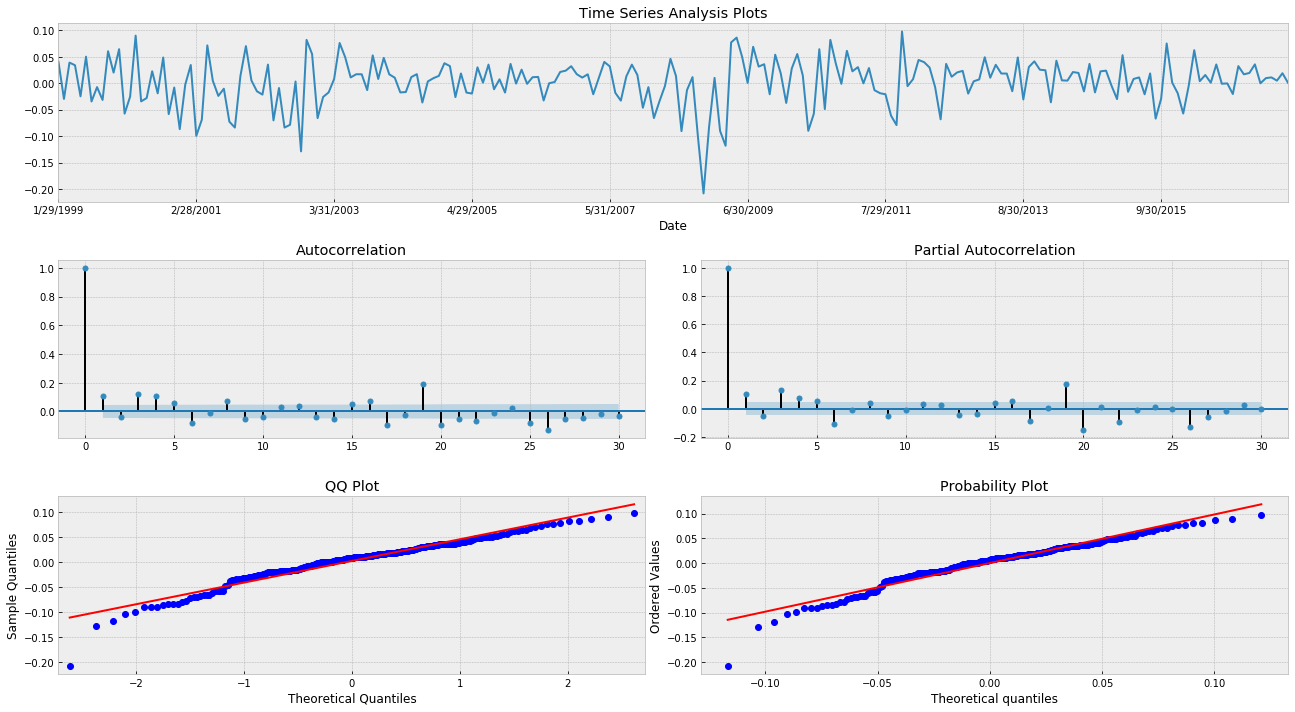

In [72]:
_ = tsplot(USA["USA"], lags=30)

In [8]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

In [9]:
test_stationarity(USA["USA"])

Results of Dickey-Fuller Test:
Test Statistic                -8.976473e+00
p-value                        7.508385e-15
#Lags Used                     6.000000e+00
Number of Observations Used    2.160000e+02
Critical Value (5%)           -2.875016e+00
Critical Value (1%)           -3.460992e+00
Critical Value (10%)          -2.573952e+00
dtype: float64


In [10]:
mod1 = sm.tsa.MarkovAutoregression(USA["USA"], k_regimes=2, order=3, switching_ar=False)
res1 = mod1.fit()
print (res1.summary())

                         Markov Switching Model Results                         
Dep. Variable:                      USA   No. Observations:                  220
Model:             MarkovAutoregression   Log Likelihood                 364.563
Date:                  Sun, 26 Nov 2017   AIC                           -713.126
Time:                          21:57:46   BIC                           -685.977
Sample:                      05-28-1999   HQIC                          -702.163
                           - 08-31-2017                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.256e-05      0.006     -0.011      0.992      -0.012       0.011
                             Regime 

In [13]:
mod2 = sm.tsa.MarkovAutoregression(USA["USA"], k_regimes=2, order=3, switching_ar=True)
res2 = mod2.fit()
print (res2.summary())

                         Markov Switching Model Results                         
Dep. Variable:                      USA   No. Observations:                  220
Model:             MarkovAutoregression   Log Likelihood                 372.610
Date:                  Sun, 26 Nov 2017   AIC                           -723.220
Time:                          21:58:50   BIC                           -685.890
Sample:                      05-28-1999   HQIC                          -708.145
                           - 08-31-2017                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0059      0.007      0.890      0.373      -0.007       0.019
ar.L1         -0.5906      0.185    

In [14]:
print(res2.expected_durations)

[ 1.73088255  3.41365106]


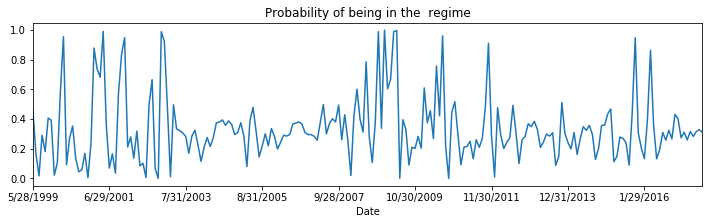

In [15]:
res2.smoothed_marginal_probabilities[0].plot(
    title='Probability of being in the  regime', figsize=(12,3))

In [152]:
#This model demonstrates estimation with regime heteroskedasticity (switching of variances) and no mean effect. 

mod_kns = sm.tsa.MarkovRegression(USA["USA"], k_regimes=2, trend='c', switching_variance=True)
res_kns = mod_kns.fit()
print(res_kns.summary())

                        Markov Switching Model Results                        
Dep. Variable:                    USA   No. Observations:                  220
Model:               MarkovRegression   Log Likelihood                 331.746
Date:                Sun, 26 Nov 2017   AIC                           -651.493
Time:                        23:33:27   BIC                           -631.131
Sample:                    05-28-1999   HQIC                          -643.270
                         - 08-31-2017                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.003     -0.233      0.816      -0.007       0.006
sigma2         0.0013      0.000      4.967      0.0

In [166]:
 m = statsmodels.tsa.regime_switching.markov_regression.MarkovRegression(USA["USA"], 
    k_regimes=2, trend='c', exog=None, order=0, exog_tvtp=None, switching_trend=True, 
    switching_exog=True, switching_variance=True)

In [167]:
res_m = m.fit()
print(res_m.summary())

                        Markov Switching Model Results                        
Dep. Variable:                    USA   No. Observations:                  220
Model:               MarkovRegression   Log Likelihood                 331.746
Date:                Sun, 26 Nov 2017   AIC                           -651.493
Time:                        23:37:45   BIC                           -631.131
Sample:                    05-28-1999   HQIC                          -643.270
                         - 08-31-2017                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.003     -0.233      0.816      -0.007       0.006
sigma2         0.0013      0.000      4.967      0.0

In [42]:
data= res2.smoothed_marginal_probabilities[0]
writer = pd.ExcelWriter( 'Prob.xlsx', engine='xlsxwriter')
   
data.to_excel(writer, 'Sheet1')

writer.save()

In [43]:
P = pd.read_excel('Prob.xlsx')
P.set_index(P['Date'], inplace=True)
P.set_index('Date', inplace=True)

In [49]:
print P.dtypes

P    float64
dtype: object


In [68]:
#Filardo (1994) Time-Varying Transition Probabilities

In [68]:
writer = pd.ExcelWriter('TED.xlsx', engine='xlsxwriter')
   
data.to_excel(writer, 'Sheet1')

writer.save()

In [73]:
FED = pd.read_excel('TED.xlsx')

In [74]:
FED.set_index(FED['Date'], inplace=True)
FED.set_index('Date', inplace=True)

In [75]:
print FED.head()

                 TR
Date               
5/28/1999  0.460301
6/30/1999  0.163149
7/30/1999  0.017348
8/31/1999  0.290629
9/30/1999  0.180539


In [147]:
model= statsmodels.tsa.regime_switching.markov_regression.MarkovRegression(USA["USA"], k_regimes=2, order=0,  exog=FED["TR"] )

In [148]:
res = model.fit()

In [149]:
print(res.summary())

                        Markov Switching Model Results                        
Dep. Variable:                    USA   No. Observations:                  220
Model:               MarkovRegression   Log Likelihood                 349.942
Date:                Sun, 26 Nov 2017   AIC                           -685.884
Time:                        23:27:55   BIC                           -662.129
Sample:                    05-28-1999   HQIC                          -676.291
                         - 08-31-2017                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0745      0.021      3.618      0.000       0.034       0.115
x1            -0.1928      0.078     -2.466      0.0